# Visualizing Hidden Layer Representations

In this notebook we will train a simple network to recognize handwritten digits on a 6x6 grid. After training we will use both Principal Components Analysis (PCA) and Hierarchical Clustering to help visualize the hidden layer representations discovered by the network.

Let's begin by getting all of the necessary libraries.

In [1]:
%pip install aitk --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from aitk.utils import array_to_image, get_dataset, gallery

## Download the data

This data consists of 24 sets of handwritten digits (0-9) for a total of 240 examples. The inputs are provided on a 6x6 grid and the outputs are one-hot vectors.

In [3]:
inputs, targets = get_dataset("digits6x6")
inputs.shape

(240, 6, 6)

In [4]:
targets.shape

(240, 10)

Let's take a look at all of the images.

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79
80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111
112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143
144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159
160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175

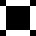
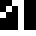
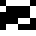
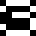
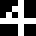
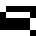
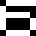
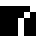
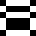
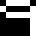
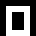
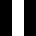
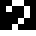
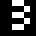
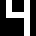
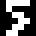
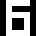
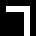
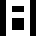
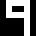
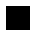
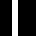
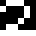
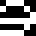
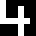
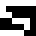
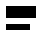
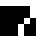
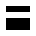
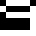
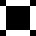
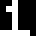
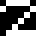
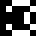
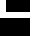
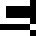
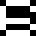
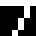
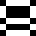
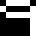
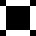
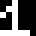
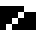
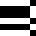
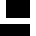
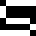
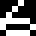
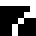
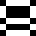
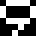
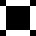
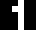
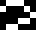
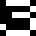
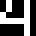
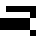
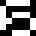
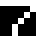
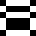
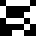
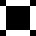
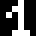
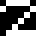
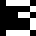
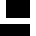
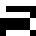
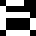
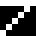
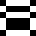
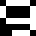
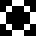
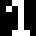
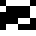
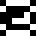
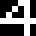
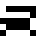
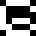
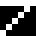
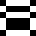
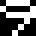
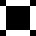
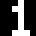
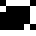
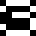
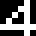
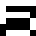
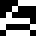
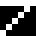
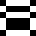
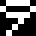
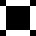
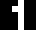
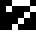
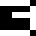
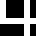
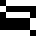
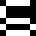
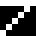
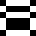
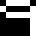
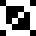
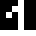
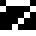
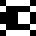
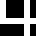
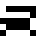
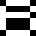
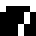
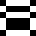
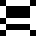
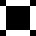
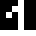
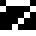
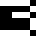
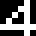
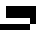
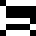
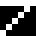
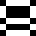
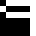
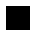
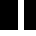
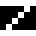
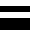
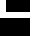
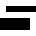
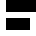
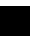
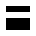
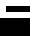
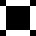
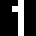
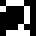
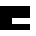
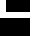
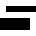
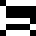
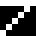
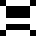
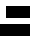
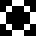
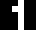
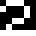
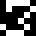
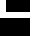
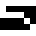
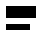
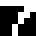
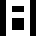
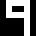
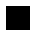
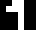
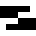
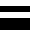
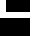
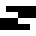
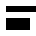
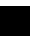
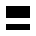
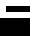
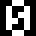
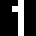
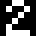
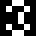
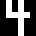
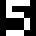
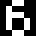
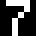
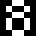
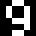
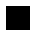
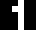
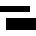
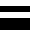
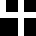
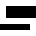
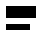
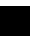
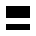
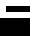
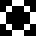
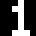
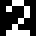
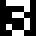
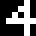
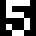
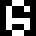
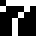
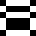
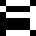
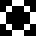
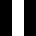
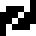
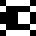
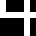
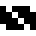
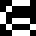
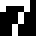
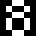
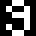
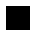
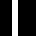
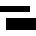
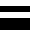
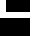
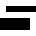
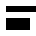
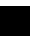
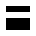
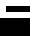
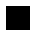
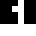
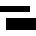
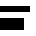
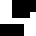
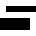
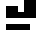
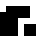
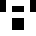
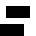
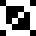
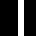
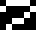
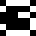
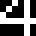
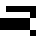
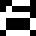
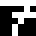
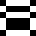
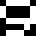
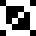
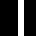
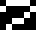
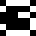
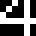
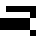
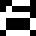
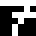
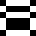
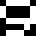

In [5]:
images = [array_to_image(inputs[i]) for i in range(len(inputs))]
bigger = [image.resize((36,36), resample=0) for image in images]
gallery(bigger)

## Build a Neural Network Model

Now we will construct a neural network to learn this data.

In [6]:
from aitk.networks import SimpleNetwork

In [7]:
def build_model():
    return SimpleNetwork(
        (6,6),
        "Flatten",
        (5, "sigmoid"),
        (10, "softmax"),
        loss = "categorical_crossentropy",
        metrics = ["tolerance_accuracy"] 
    )

In [8]:
net = build_model()
net.set_tolerance(0.15)

2024-06-13 14:57:00.347313: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-13 14:57:04.848584: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-13 14:57:04.861972: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-13 14:57:04.862099: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-13 14:57:04.862436: I tensorflow/core/

In [9]:
net.summary()

Model: "SimpleNetwork"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 6, 6)]            0         
                                                                 
 flatten (Flatten)           (None, 36)                0         
                                                                 
 hidden_2 (Dense)            (None, 5)                 185       
                                                                 
 output (Dense)              (None, 10)                60        
                                                                 
Total params: 245
Trainable params: 245
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = net.fit(
    inputs, targets, 
    batch_size=16, 
    shuffle=True,
    epochs=300, 
    accuracy=1.0, 
    patience=30, 
    report_rate=10,
)

Stopped because accuracy beat goal of 1.0
Epoch 283/300 loss: 0.009348977357149124 - tolerance_accuracy: 1.0


## Test the Trained Network

We can test how well the network has learned the data by propagating some of the input patterns through the trained network.

In [11]:
from time import sleep
for pattern in inputs[0:20]:
    net.display(pattern)
    sleep(1.0)

## Principal Components Analysis

We would like to understand more about how the network has learned to categorize the images properly. One way to think about what a neural network is doing, is that each layer of weights is transforming the input into new representations that help the network distinguish between the desired categories. 

Let's focus on the hidden layer, which has transformed the 36 pixel values into a representation that is 5 long. Unfortunately we can't easily visualize 5 dimensions. However, PCA allows us to focus on just 2 dimensions where the most change is happening. 


In [12]:
# Give each digit it's own color
visualize = ["pink", "red", "orange", "yellow", "green", 
           "teal", "blue", "indigo", "violet", "black"]

We will assign a unique color to every hidden representation based on what digit it encodes:

In [13]:
encoding = list(zip(range(10),visualize))
print(encoding)

[(0, 'pink'), (1, 'red'), (2, 'orange'), (3, 'yellow'), (4, 'green'), (5, 'teal'), (6, 'blue'), (7, 'indigo'), (8, 'violet'), (9, 'black')]


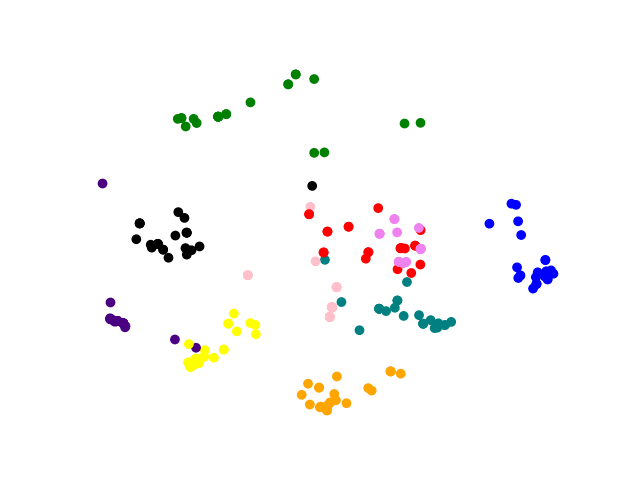

In [14]:
net.set_pca_spaces(inputs)
net.predict_pca_to(inputs, 'hidden_2', visualize*24, None)

We would expect that the hidden layer has done some of the work of transforming the data to make it easier for the output layer to choose the right category.  Each run of the network will likely be slightly different, but notice that some of the digits are clustered together nicely, while others are more spread out and intermixed. Look at the color coding above and determine which digits are intermixed. Does this make sense given how these digits might have similary sub-structures in them?

## Cluster Analysis

Another way to analyze the hidden layer representation is to do a cluster analysis. Here we consider every hidden layer representation and calculate the Euclidean distance between every possible pair. The two closest examples form a cluster and their average is put back into the set of representations. We continue this process until a complete tree has been formed. 

In [15]:
from scipy.cluster import hierarchy

In [16]:
labelList = [str(v) for v in range(10)]

In [17]:
hidden_raw = net.predict_to(inputs, "hidden_2")

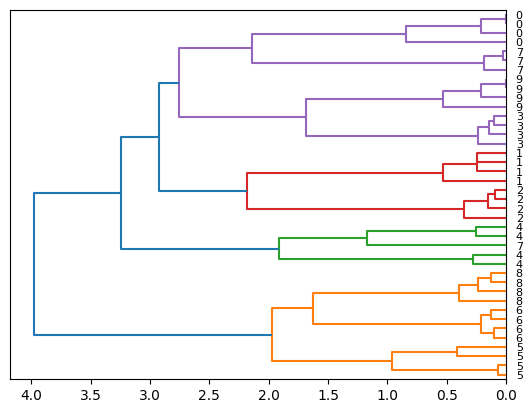

In [18]:
result = hierarchy.dendrogram(
    hierarchy.linkage(hidden_raw[0:40],method='ward'),
    orientation="left", 
    labels=labelList*4,
)

Notice that the neural network will typically discover hidden layer representations such that all digits of the same type are closer to one another than to other digits. 